In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from utils.util import data_shift
import hiplot as hip
from matplotlib import pyplot as plt
import sys
from copy import copy
import warnings
warnings.filterwarnings("ignore")

Before starting this exercise, you need to install the library firstly:

- hiplot: conda install -c conda-forge hiplot

### Task 1: Neural Network Implementation and Optimization

In this exercise you need to implement a fully-connected neural network using PyTorch to forecast daily minimum temperatures.

**a)** Import temperature time-series dataset **daily-minimum-temperatures.csv** in the data folder. 

In [69]:
data = pd.read_csv('./data/daily-minimum-temperatures.csv',header=0, index_col=0)
data.head(10)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
1981-01-06,15.8
1981-01-07,15.8
1981-01-08,17.4
1981-01-09,21.8


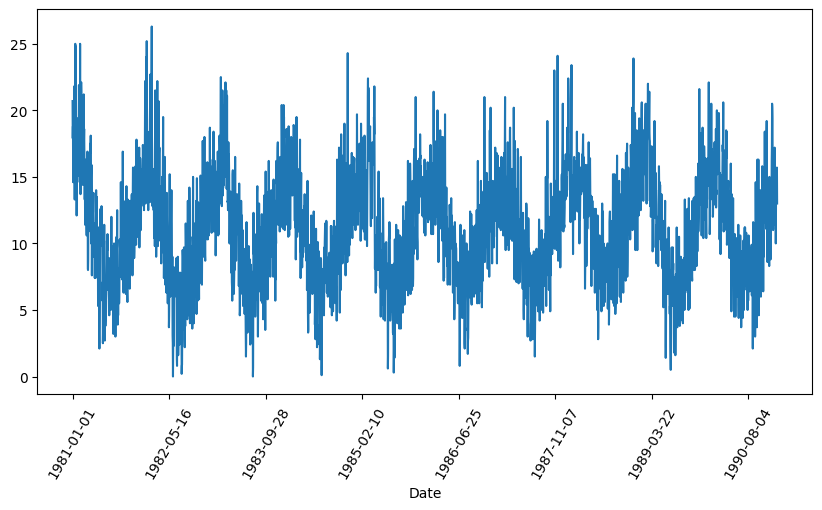

In [70]:
# Visualize the data
plt.figure(figsize=(10,5))
data['Temp'].plot(rot=60)
plt.show()

**b)** Generate a **7**-lag input dataset manually, i.e., use the previous 7 days data \[x(t-7), x(t-6)...x(t-1)\] as the input to predict the following day X(t) using the given function **data_shift()**.

In [71]:
lags = 7
train, test = data[0:-50], data[-50:]

# Scaling the train/test data using minmaxscaler
scaler = MinMaxScaler().fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=data.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=data.columns)

print(train_scaled.head(5))
print(test_scaled.head(5))

       Temp
0  0.787072
1  0.680608
2  0.714829
3  0.555133
4  0.600760
       Temp
0  0.479087
1  0.524715
2  0.555133
3  0.501901
4  0.467681


In [72]:
# Generate the shifted training/test dataset, using the given function data_shift()
train_shifted, test_shifted = data_shift(train=train_scaled, test=test_scaled)

# Split the train/test dataset to train_X, train_y / test_X, test_y
train_y = train_shifted['t']
train_X = train_shifted.drop(columns=['t'])

test_y = test_shifted['t']
test_X = test_shifted.drop(columns=['t'])

# Convert the train/test dataset to tensors, the data type is torch.float32
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X.values, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y.values, dtype=torch.float32)

print(train_X_tensor[:3])
print(train_y_tensor[:3])
print(test_X_tensor[:3])
print(test_y_tensor[:3])

tensor([[0.7871, 0.6806, 0.7148, 0.5551, 0.6008, 0.6008, 0.6008],
        [0.6806, 0.7148, 0.5551, 0.6008, 0.6008, 0.6008, 0.6616],
        [0.7148, 0.5551, 0.6008, 0.6008, 0.6008, 0.6616, 0.8289]])
tensor([0.6616, 0.8289, 0.7605])
tensor([[0.4791, 0.5247, 0.5551, 0.5019, 0.4677, 0.3346, 0.4068],
        [0.5247, 0.5551, 0.5019, 0.4677, 0.3346, 0.4068, 0.3764],
        [0.5551, 0.5019, 0.4677, 0.3346, 0.4068, 0.3764, 0.3156]])
tensor([0.3764, 0.3156, 0.5703])


**c)**  Complete the given class **dnn()** using PyTorch to implement a neural network.

Hints:

- [**nn.Sequential()**](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

In [73]:
class dnn(nn.Module):
    def __init__(self, input_size=7, network_structure=[16, 4], output_size=1, activation_function='sigmoid', 
                 dropout_rate=0.2, leaky_relu_slop=0.01, output_activation_function=None):
        super().__init__()
        """
        Initialization.
        input_size: int, the dimension of the input features.
        network_structure: list, the strcture of the hidden layers in the network, each number corresponds to the number 
                           of neuros in a hidden layer.
        output_size: int, the dimension of the prediction target.
        activation_function: string, the name of the selected activation function in hidden layers. Implement the function
                             str2act() to convert the string to activation function.
        dropout_rate: float, the probability of an element to be zeroed.
        leaky_relu_slop: float, controls the angle of the negative slope for the function leakyrelu.
        output_activation_function: string, the name of the selected activation function in output layer.       
        """
        self.input_size = input_size
        self.output_size = output_size
        self.leaky_relu_slop = leaky_relu_slop
        self.activation_function = self.str2act(activation_function)
        self.output_activation_function = self.str2act(output_activation_function)
        self.dropout = nn.Dropout(dropout_rate)
        self.network_structure = copy(network_structure)
        self.network_structure.insert(0, self.input_size)
        
        # Implement the neural network model using pytorch modules based on the given input/output size 
        # and the network structure.
        
        module_list = []

        for in_size, out_size in zip(self.network_structure[:-1], self.network_structure[1:]):
            module_list.append(nn.Linear(in_size, out_size))
            module_list.append(self.dropout)
            if self.activation_function is not None:
                module_list.append(self.activation_function)

        module_list.append(nn.Linear(out_size, self.output_size))
        if self.output_activation_function is not None:
            module_list.append(self.output_activation_function)

        self.model = nn.Sequential(*module_list)

        
    def forward(self, x):
        '''
        x: torch.tensor, the input
        
        Feedforward propagation of the input to the output. 
        '''
        x = self.model(x)   
        return x
    
    def predict(self, x):
        '''
        x: troch.tensor, the input
        
        Make a prediction for the input. The mode should be set to evaluation mode there.
        '''
        training_mode = self.training # store the current mode
        self.eval() # to evaluation mode
        
        # predict
        output = self.model(x)
        
        self.train(training_mode) # reset the saved mode
        return output
    
    def str2act(self, str):
        '''
        Convert the given string to the corresponding activation function.
        '''
        
        if str == "sigmoid":
            return nn.Sigmoid()
        
        elif str == "tanh":
            return nn.Tanh()     
        
        elif str == "relu":
            return nn.ReLU()
            
        elif str == "leakyrelu":
            return nn.LeakyReLU()
            
        elif str == None:
            # No activate function is required.
            # the function should return the input
            return None

In [74]:
model = dnn()
model

dnn(
  (activation_function): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (model): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Sigmoid()
    (3): Linear(in_features=16, out_features=4, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

**d)** Train the **model** using mini-batch gradient descent.

Hints:

- Convert the training tensors to iterable objects using the data loading utility [**DataLoader()**](https://pytorch.org/docs/stable/data.html). 

- Use [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) as the loss function

- Use SGD with a optimial learning rate as the [optimizer](https://pytorch.org/docs/stable/optim.html).

In [75]:
epochs = 256
batch_size = 32
input_size = train_X_tensor.shape[1]
output_size = 1
network_structure = [64, 32, 16, 1]
activation_function = 'leakyrelu'
leaky_relu_slop = 0.01
dropout_rate = 0
output_activation_function = None

# Convert the training tensors to iterable objects
dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = dnn(
    input_size, 
    network_structure, 
    output_size, 
    activation_function, 
    dropout_rate, 
    leaky_relu_slop,
    output_activation_function
)

# Define loss function
loss_function = nn.MSELoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.999)

In [76]:
train_losses = [] # save the average training loss of each iteration
test_losses = [] # save the average test loss of each iteration

# Training process
for epoch in range(epochs):
    # set training mode
    model.train()
    epoch_loss = 0.0
    
    # Implement the training loop using mini-batch 
    for idx, batch in enumerate(train_loader):
        x, y = batch[0], batch[1]
        optimizer.zero_grad()
        y_pred = model.forward(x)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    # compute test error in each epoch and add it to test_losses
    # Do the same for training loss as well
    # print the test error in each 10 epochs

    y_pred = model.predict(test_X_tensor)
    test_error = loss_function(y_pred, test_y_tensor).item()
    train_error = epoch_loss / (idx+1)
    train_losses.append(train_error)
    test_losses.append(test_error)
    if epoch % 10 == 0:
        print(f'[{epoch+1}/{epochs}]: Train loss: {train_error}, Test loss: {test_error}')

[1/256]: Train loss: 0.15142955757117113, Test loss: 0.11012813448905945
[11/256]: Train loss: 0.07438057250615242, Test loss: 0.16476798057556152
[21/256]: Train loss: 0.04573606882260832, Test loss: 0.04333534464240074
[31/256]: Train loss: 0.026590377941266098, Test loss: 0.013966716825962067
[41/256]: Train loss: 0.015828502685886568, Test loss: 0.017573921009898186
[51/256]: Train loss: 0.013117277448733164, Test loss: 0.015532441437244415
[61/256]: Train loss: 0.012888302894688286, Test loss: 0.015015969052910805
[71/256]: Train loss: 0.012369578259181132, Test loss: 0.013241994194686413
[81/256]: Train loss: 0.01250579320636075, Test loss: 0.0132551658898592
[91/256]: Train loss: 0.012418690704188384, Test loss: 0.013205341063439846
[101/256]: Train loss: 0.012383670628532371, Test loss: 0.013154490850865841
[111/256]: Train loss: 0.01239812412645371, Test loss: 0.01333548966795206
[121/256]: Train loss: 0.012373880804640002, Test loss: 0.013226479291915894
[131/256]: Train loss

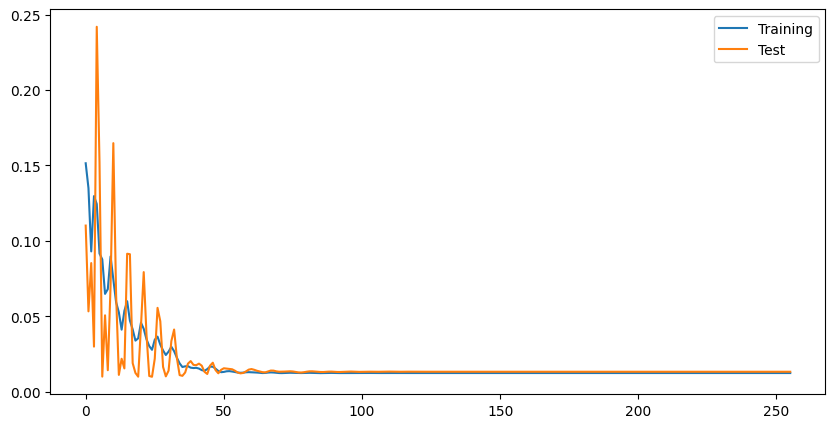

In [78]:
# Plot the learning curve
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Training")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

In [ ]:
# Plot the comparison between measurements and predictions of the training data
### Your Code Here ### 

In [ ]:
# Plot the comparison between measurements and predictions of the test data
### Your Code Here ### 

In [ ]:
# What problem you can observe in this figure? What could cause this problem?

**e)** Implement [**Early Stopping**](https://en.wikipedia.org/wiki/Early_stopping) in the training process.

In [ ]:
## Re-initialize the model
### Your Code Here ### 

# The training process is monitored and stopped when the loss doesn't decrease within 30 iterations.
early_stop_patience = 30

train_losses = [] # save the average training loss of each iteration
test_losses = [] # save the average test loss of each iteration
best_epoch = 0 # the epoch of the lowest test loss
lowest_loss = sys.float_info.max # the current lowest test loss
epochs_counter = 0 # count how many epochs have been monitored and compare the number to the patience.

# Define loss function
### Your Code Here ### 

# Define optimizer SGD
### Your Code Here ### 

# Define optimizer Adam (for subtask f)
### Your Code Here ### 

# Training process
for epoch in range(epochs):
    # set training mode
    model.train()
    running_losses = 0.0
    
     # Implement the training loop using mini-batch
    for idx, batch in enumerate(loader):
        pass
        ### Your Code Here ### 
    
    # compute test error in each epoch and add it to test_losses
    # Do the same for training loss as well
    # print the test error in each 10 epochs
    
    ### Your Code Here ###
    
    # Implment early stopping
    # Update the lowest loss, when the newest test loss is smaller.
    # Otherwise stop_epochs += 1
    # Stop learning and return the lowest test loss, when the stop_epochs is greater than or equal to
    # the early_stop_patience
    
    ### Your Code Here ###

In [ ]:
# Plot the comparison between measurements and predictions of the test data
### Your Code Here ###

**f)** Try [**Adam**](https://pytorch.org/docs/stable/optim.html) optimzer based on the code of sub-task **e** and plot the learning curve. What different can you observe between the learning curve of SGD and Adam.

**g)** Search the optimal hyperarameters using **grid search** and visualize the searching results with [HiPlot](https://github.com/facebookresearch/hiplot).

- Optimize these hyperparameters: **the structure of neural networks** (i.e., the number of neuros and layers), **activation functions**, **dropout rates**, **optimizers**, **learning rate**.

- The searching range can be adjusted depending on your hardware condition.

In [ ]:
nn_structures = [[32, 16, 1], [64, 32, 16, 1]]
activation_functions = ['tanh', 'sigmoid']
dropout_rates = [0.2, 0.05]
learning_rates = [0.05, 0.01]
optimizers = ['adam', 'sgd']
results = []
param_idx = 1

# The training process is monitored and stopped when the loss doesn't decrease within 30 iterations.
early_stop_patience = 30

# Search the optimal parameters using grid search
for nn_structure in nn_structures:
    for activation_function in activation_functions:
        for dropout_rate in dropout_rates:
            for learning_rate in learning_rates:
                for optimizer_str in optimizers:
                    
                    # Training settings
                    # declare variables, e.g. losses list, lowest loss etc
                    # initialize the neural network, optimizer, and the corresponding loss function.
                    ### Your Code Here ###
                    
                    print(f"The index of the hyparameter set: {param_idx}")
                    
                    # Implement the training loop using mini-batch
                    for epoch in range(epochs):
                        # set training mode
                        model.train()
                        running_losses = 0.0
                        
                        # Implement the training loop using mini-batch
                        for idx, batch in enumerate(loader):
                            pass
                            ### Your Code Here ###
                        
                        # compute test error in each epoch and add it to test_losses
                        # Do the same for training loss as well
                        # print the test error in each 10 epochs
                        
                        ### Your Code Here ###
                        
                        # Implment early stopping
                        # Update the lowest loss, when the newest test loss is smaller.
                        # Otherwise stop_epochs += 1
                        # Stop learning and return the lowest test loss, when the stop_epochs is greater than or equal to
                        # the early_stop_patience
                        
                        ### Your Code Here ###
                        
                    # Store the parameters and the result for displaying    
                    results.append({"Structure": nn_structure,
                                    "activation function": activation_function,
                                    "dropout rate": dropout_rate,
                                    "learning rate": learning_rate,
                                    "optimizer": optimizer_str,
                                    "test error": lowest_loss
                                    })
                    param_idx += 1

In [ ]:
# Visualize the results in parallel plots.
hip.Experiment.from_iterable(results).display()